<h1 align="center">EQE512 MATRIX METHODS IN STRUCTURAL ANALYSIS 
<br>
<br>
Week 10
<br>
<br>
Frame Systems- OpenSeesPy Modeling</h1> 

<h3 align="center">Dr. Ahmet Anıl Dindar (adindar@gtu.edu.tr)</h3> 
<h4 align="center">2021 Fall  </h4> 

---
**Today's Topics**

This code is composed of three sections, namely 

A. Pre-process

B. Process

C. Post-Process

---

Problem: This is a multistory 2D Elastic RC frame under static loads

---

# A. Pre-Process

## importing opensees modules

In [230]:
import openseespy.opensees as ops

In [231]:
ops.wipe() # Clear all OS values

In [232]:
ops.model( "Basic" , "-ndm", 2 , "-ndf",3)

## Creating the model

### System geometry

In [233]:
numBay = 2
numFloor = 3
#-----------------
bayWidth = 3.0 # m
storyHeight = 3.0 # m

### Material

In [234]:
E = 29_500_000 # kN/m2

### Transformation type

In [235]:
coordTransfer = "Linear"

In [236]:
### Mass source

In [237]:
massX = 0.49
M = 0
massType = "-lMass" # Lumped mass

### Members

In [238]:
beams = [ "B20X50" for item in range( numFloor)]

In [239]:
eColumn = ["C50X50" for item in range( numFloor)]
iColumn = ["C50X50" for item in range( numFloor)]

columns =  [ eColumn , iColumn , eColumn]

In [240]:
columns

[['C50X50', 'C50X50', 'C50X50'],
 ['C50X50', 'C50X50', 'C50X50'],
 ['C50X50', 'C50X50', 'C50X50']]

### Sections

In [241]:
Section = {"C50X50" : [ 0.5 * 0.5 , (0.5 * 0.5**3)/12],
           "B20X50": [ 0.2 * 0.5 , (0.2 * 0.5**3) / 12]}

### Create the members in the Model

In [242]:
def ElastBeamColumn( eleTag, iNode, jNode, sectType, E, transfTag, M, massType ):
    
    prop = Section[sectType]
    Area = prop[0]
    I = prop[1]
    
    ops.element( "elasticBeamColumn", eleTag ,iNode, jNode, Area, E , I , transfTag , "-mass", M, massType)


### Creating the axis

In [243]:
import numpy as np

axis_h = np.linspace( 0 , (numBay * bayWidth) , numBay+1 )
axis_v = np.linspace( 0 , (numFloor * storyHeight) , numFloor+1 )

print( f"Axis Horizontal {axis_h} and Story levels {axis_v}" )

Axis Horizontal [0. 3. 6.] and Story levels [0. 3. 6. 9.]


In [244]:
node_no = 1
node_dict = {}
floorNo = 0 
floorNodes = {}
nodes = []

for i in axis_v : 
    floorNodes[ floorNo] = []
    for j in axis_h : 
        nodes.append( node_no)
        
        #OpenSees Command
        ops.node( node_no , float( j ) , float( i ))
        
        # Store info i nthe dictionaries
        node_dict[ node_no ] = [float( j ) , float( i )]
        floorNodes[ floorNo].append( node_no)
        
        node_no += 1
        
    floorNo += 1

In [245]:
node_dict

{1: [0.0, 0.0],
 2: [3.0, 0.0],
 3: [6.0, 0.0],
 4: [0.0, 3.0],
 5: [3.0, 3.0],
 6: [6.0, 3.0],
 7: [0.0, 6.0],
 8: [3.0, 6.0],
 9: [6.0, 6.0],
 10: [0.0, 9.0],
 11: [3.0, 9.0],
 12: [6.0, 9.0]}

In [246]:
floorNodes

{0: [1, 2, 3], 1: [4, 5, 6], 2: [7, 8, 9], 3: [10, 11, 12]}

### Boundary Conditions

In [247]:
for nodeNumber in floorNodes[ 0 ]:
    ops.fix( nodeNumber , 1 , 1 , 1)

### Rigid Diaphram Assignments

In [248]:
for key , value in floorNodes.items():
    for item in value[:]:
        if item == value[0]:
            ops.mass( item , massX , 0.000001 , 0.0000001)
        else: 
            ops.equalDOF( value[0] , item , 1)

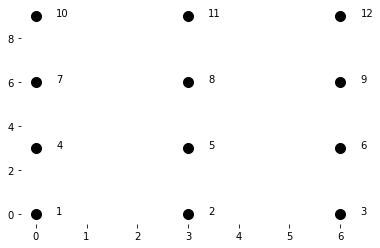

In [249]:
import matplotlib.pyplot as plt
%matplotlib inline

for key in node_dict.keys():
    plt.plot( node_dict[key][0] ,  node_dict[key][1] , "o" , c = "k" , mec = "k" , ms = 10 )
    plt.text( node_dict[key][0]+.4 ,  node_dict[key][1] , str(key) ,  )
    
plt.box( False)

### Assign the columns

In [250]:
ops.geomTransf(coordTransfer, 1)

In [251]:
column_dict = {}
eleTag = 1 
for j in range( 0 , numBay + 1):
    end1 = j + 1
    end2 = end1 + numBay + 1
    thisColumn = columns[j]
    for i in range( 0 , numFloor) :
        secType = thisColumn[ i ]
        ElastBeamColumn( eleTag , end1 , end2 , secType , E , 1 , M , massType) # This is my command with ops command inside
        # store info in dict
        column_dict[ eleTag ] = [end1 , end2]
        end1  = end2 
        end2 += numBay + 1
        eleTag += 1

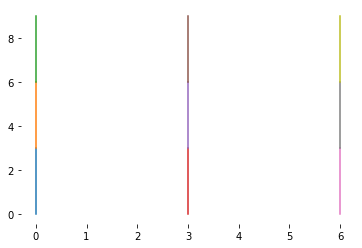

In [252]:
for key in column_dict.keys():
    plt.plot([ node_dict[column_dict[key][0]][0] ,node_dict[column_dict[key][1]][0]],
              [ node_dict[column_dict[key][0]][1] ,node_dict[column_dict[key][1]][1]]  )
plt.box(False)

### Beam Assignment 

In [253]:
beam_dict = {}
for j in range( 1 , numFloor + 1):
    end1 = (numBay + 1 ) * j + 1
    end2 = end1 + 1
    secType = beams[ j - 1]
    
    for i in range( 0 , numBay) :
        ElastBeamColumn( eleTag , end1 , end2 , secType , E , 1 , M , massType)
        # store info in dict
        beam_dict[ eleTag ] = [end1 , end2]
        end1 = end2 
        end2 = end1 + 1
        eleTag +=1 

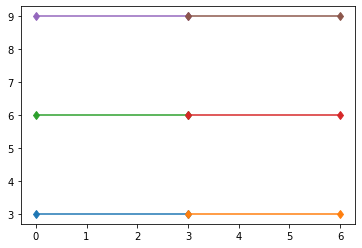

In [254]:
for key in beam_dict.keys():
    plt.plot([ node_dict[beam_dict[key][0]][0] ,node_dict[beam_dict[key][1]][0]],
              [ node_dict[beam_dict[key][0]][1] ,node_dict[beam_dict[key][1]][1]] , marker = "d" )

### Visualization

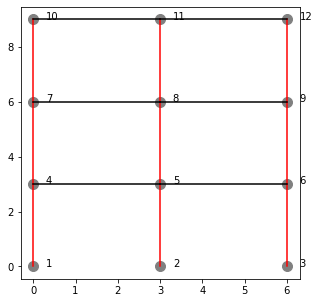

In [255]:
plt.figure(figsize= (5,5))


for key in node_dict.keys():
    plt.plot( node_dict[key][0] ,  node_dict[key][1] , "o" , MS = 10 , color="gray")
    plt.text( node_dict[key][0]+.3 ,  node_dict[key][1] , key )
for key in column_dict.keys():
    plt.plot([ node_dict[column_dict[key][0]][0] ,node_dict[column_dict[key][1]][0]],
              [ node_dict[column_dict[key][0]][1] ,node_dict[column_dict[key][1]][1]]  
            , color="red")
for key in beam_dict.keys():
    plt.plot([ node_dict[beam_dict[key][0]][0] ,node_dict[beam_dict[key][1]][0]],
              [ node_dict[beam_dict[key][0]][1] ,node_dict[beam_dict[key][1]][1]] 
            , color="k")
    

## Loads in the system

In [256]:
ops.timeSeries( "Linear" , 1 )

In [257]:
ops.pattern( "Plain"  , 1 , 1)

load_dict = { 4 : 2_000 , 7 : 2_000 , 10 : 2_000}

for key , value in load_dict.items():
    ops.load( key , value , 0 ,0 )

# B. Process

In [258]:
ops.integrator('LoadControl', 1.0)
ops.algorithm('Linear')
ops.analysis('Static')
analysis_resut = ops.analyze(1)

if analysis_resut == 0 : 
    print( "Analysis complete")

Analysis complete


WARNING analysis Static - no ConstraintHandler yet specified, 
 PlainHandler default will be used
WARNING analysis Static - no Numberer specified, 
 RCM default will be used
WARNING analysis Static - no LinearSOE specified, 
 ProfileSPDLinSOE default will be used
WARNING PlainHandler::handle() -  constraint at dof 0 already specified for constrained node in MP_Constraint at node 2
WARNING PlainHandler::handle() -  constraint at dof 0 already specified for constrained node in MP_Constraint at node 3


# C. Post-Process

In [259]:
for node in [  4 , 7 , 10 ] :
    print( ops.nodeDisp( node  ) )

[0.0640437931289212, 0.00158914974168947, -0.02486768350876392]
[0.1459975876623622, 0.0024518961766870837, -0.019357987495421686]
[0.1986051948373229, 0.002742095251829584, -0.011104356073484537]


In [260]:
ops.nodeVel( 10)

[0.0, 0.0, 0.0]

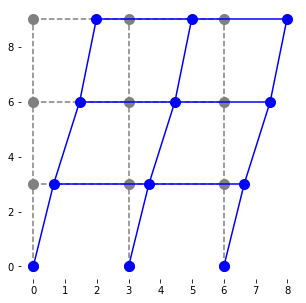

In [262]:
scale = 10
node_deform_dict = {}
for i in node_dict.keys():
    node_deform_dict[i] = [node_dict[i][0] + scale*(ops.nodeDisp(i,1)) , node_dict[i][1]]
#    print( f"{i} node disp = {round( ops.nodeDisp(i,1),5)}")

plt.figure(figsize= (5,5))
for key in node_dict.keys():
    plt.plot( node_dict[key][0] ,  node_dict[key][1] , "o" , MS = 10 , color="gray")
for key in column_dict.keys():
    plt.plot([ node_dict[column_dict[key][0]][0] ,node_dict[column_dict[key][1]][0]],
              [ node_dict[column_dict[key][0]][1] ,node_dict[column_dict[key][1]][1]]  
            ,"--", color="gray")
for key in beam_dict.keys():
    plt.plot([ node_dict[beam_dict[key][0]][0] ,node_dict[beam_dict[key][1]][0]],
              [ node_dict[beam_dict[key][0]][1] ,node_dict[beam_dict[key][1]][1]] 
            , "--",color="gray")

for key in node_deform_dict.keys():
    plt.plot( node_deform_dict[key][0] ,  node_deform_dict[key][1] , "o" , MS = 10 , color="b")
for key in column_dict.keys():
    plt.plot([ node_deform_dict[column_dict[key][0]][0] ,node_deform_dict[column_dict[key][1]][0]],
              [ node_deform_dict[column_dict[key][0]][1] ,node_deform_dict[column_dict[key][1]][1]]  
            , color="b")
for key in beam_dict.keys():
    plt.plot([ node_deform_dict[beam_dict[key][0]][0] ,node_deform_dict[beam_dict[key][1]][0]],
              [ node_deform_dict[beam_dict[key][0]][1] ,node_deform_dict[beam_dict[key][1]][1]] 
            , color="b")
plt.box(False)

---

**NEXT WEEK**
The topics for the next week 

- Dynamic characteristics of the systems, computations ( SDOF-MDOF) Mod superposition and application in Earthquake Engineering (MDOF)Dynamic characteristics of the systems, computations ( SDOF-MDOF) Mod superposition and application in Earthquake Engineering (MDOF)